In [1]:
from langchain_core.messages import HumanMessage
from app.src.graph import build_scrape_graph, build_scrape_graphv2, build_url_graph, build_graph, build_analize_graph

graph = build_scrape_graphv2(model='ollama', temperature=0.0)

#user_input = input("Enter a message: ")
user_input = "quiero un depto en la plata para una persona moderno con cochera"
print(user_input)
state = graph.invoke({"query": [HumanMessage(content=user_input)]})

print(state["properties"])

quiero un depto en la plata para una persona moderno con cochera
Accessing webpage: https://www.zonaprop.com.ar/departamentos-alquiler-la-plata-1-habitacion-1-garage.html
[{'id': '55835970', 'price': {'monthly_rent': '$ 583.000', 'maintenance_fee': '$ 80.000 Expensas', 'total_price': 663000, 'price_per_sqm': 14107}, 'location': {'address': '58 e/ 18 y Avenida 19', 'neighborhood': 'La Plata, La Plata'}, 'specifications': {'total_area_m2': 47, 'rooms': 2, 'bedrooms': 1, 'bathrooms': 1, 'parking_spaces': 1, 'floor_level': 'high'}, 'features': ['elevator', 'balcony', 'built_in_closet', 'equipped_kitchen', 'bright', 'spacious'], 'url': 'https://www.zonaprop.com.ar/propiedades/clasificado/alclapin-departamento-en-alquiler-1-dormitorio-1-bano-47-55835970.html', 'description': 'Sumamos facilidades de pago: Ahora podes abonar los honorarios del alquiler con tarjeta y en cuotas-Tarjetas de crédito visa o mastercard hasta en 3 cuotas sin interes -Tarjetas de debito en 1 pago sin interés_ Departam

In [3]:
import json
json.dumps(state["properties"], indent=2, ensure_ascii=False)

with open("properties.json", 'w') as file:
    json.dump(state["properties"], file, indent=4)

In [3]:
from langchain_core.messages import HumanMessage
from src.graph import build_graph

graph = build_graph(model='ollama', temperature=0.0)

user_input = input("Enter a message: ")
print(user_input)
state = graph.invoke({"query": [HumanMessage(content=user_input)]})

print(state["query"][-1].content)

KeyboardInterrupt: Interrupted by user

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_community.chat_models import ChatOllama
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from pydantic.networks import AnyUrl
from langchain_core.messages import HumanMessage


In [3]:
load_dotenv()

llm = init_chat_model("ollama:deepseek-r1:latest")


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


graph = graph_builder.compile()

user_input = input("Enter a message: ")
state = graph.invoke({"messages": [{"role": "user", "content": user_input}]})

print(state["messages"][-1].content)

<think>

</think>

Hello! How can I assist you today? 😊


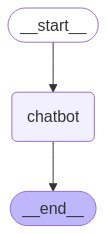

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [2]:
load_dotenv()

llm = init_chat_model("ollama:gemma3:12b")

class MessageURL(BaseModel):
    url: AnyUrl = Field(description="A functional ZonaProp URL based on the user's real estate query")

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    query: Annotated[list, add_messages]
    url: AnyUrl | None

graph_builder = StateGraph(State)


def url_agent(state: State):
    """Create a URL from the query.
    """
    last_message = state["query"][-1]
    url_llm = llm.with_structured_output(MessageURL)

    result = url_llm.invoke([
        {
            "role": "system",
            "content": f"""
                You are an assistant that generates ZonaProp property listing URLs based on the user's message.

                ## ZonaProp URL Format
                Base structure:
                https://www.zonaprop.com.ar/[property-type]-[operation]-[location]-[additional-filters].html

                ### Required Components (must always be included):
                1. **Property Type**
                - departamentos (apartments)
                - casas (houses)
                - ph (Horizontal Property)
                - cocheras (parking)
                - terrenos (land)
                - oficinas (offices)
                - locales (commercial)
                - Combined types: e.g., casas-departamentos-ph

                2. **Operation**
                - venta (sale)
                - alquiler (rent)
                - alquiler-temporal (temporary rental)

                3. **Location**
                - Examples: capital-federal, palermo, la-plata, rosario
                - Can include neighborhoods, cities, or provinces

                ---

                ### Optional Filters (include only if user provides relevant info):
                4. **Rooms (ambientes)**
                - e.g., 1-ambiente, 2-ambientes, mas-de-3-ambientes, desde-2-hasta-3-ambientes

                5. **Bedrooms (habitaciones)**
                - e.g., 1-habitacion, hasta-3-habitaciones, desde-2-hasta-3-habitaciones

                6. **Bathrooms (baños)**
                - e.g., 2-banos, mas-de-1-bano, desde-1-hasta-2-banos

                7. **Garages**
                - e.g., 1-garage, sin-garages, mas-de-1-garage, desde-1-hasta-2-garages

                8. **Price**
                - e.g., menos-200000-dolares, mas-de-100000-pesos, desde-100000-hasta-300000-dolares

                9. **Age**
                - e.g., a-estrenar, hasta-10-anos, mas-de-20-anos

                10. **Sorting**
                - orden-precio-ascendente
                - orden-publicacion-descendente

                11. **Publication Date**
                - publicado-hoy
                - publicado-hace-menos-de-1-semana
                - publicado-hace-menos-de-1-mes

                ---

                ### Rules & Behavior
                - All terms in the URL must be lowercase and hyphen-separated.
                - If key info is missing, **infer as a real estate agent would** or omit the filter.
                - **Always include** property type, operation, and location.
                - **Only output the URL.**
            """
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ])
    return {"url": result.url}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("url_agent", url_agent)
graph_builder.add_edge(START, "url_agent")
graph_builder.add_edge("url_agent", END)


graph = graph_builder.compile()

user_input = input("Enter a message: ")
state = graph.invoke({"query": [HumanMessage(content=user_input)]})

print(state["url"])

https://www.zonaprop.com.ar/departamentos-alquiler-la-plata-desde-3-ambientes-1-habitacion.html
